In [1]:
%%capture --no-display
!pip install pandas scikit-learn seaborn nltk wordcloud

In [59]:
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet

In [67]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/guillaume/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Impose a seed for reproducibility
random_seed = 421

In [4]:
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=random_seed,
)

In [5]:
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: dataset.target_names[x])

In [6]:
unique_labels = np.unique(df['label'])
number_of_unique_labels = len(unique_labels)
number_of_samples = len(df['text'])
print('There are {} different labels that describe a total of {} documents.'.format(
    number_of_unique_labels, number_of_samples))

There are 20 different labels that describe a total of 18846 documents.


The 20 different labels are the following. We note that the distribution is not uniform, there is a class imbalance.
**TODO**

0: alt.atheism
1: comp.graphics
2: comp.os.ms-windows.misc
3: comp.sys.ibm.pc.hardware
4: comp.sys.mac.hardware
5: comp.windows.x
6: misc.forsale
7: rec.autos
8: rec.motorcycles
9: rec.sport.baseball
10: rec.sport.hockey
11: sci.crypt
12: sci.electronics
13: sci.med
14: sci.space
15: soc.religion.christian
16: talk.politics.guns
17: talk.politics.mideast
18: talk.politics.misc
19: talk.religion.misc


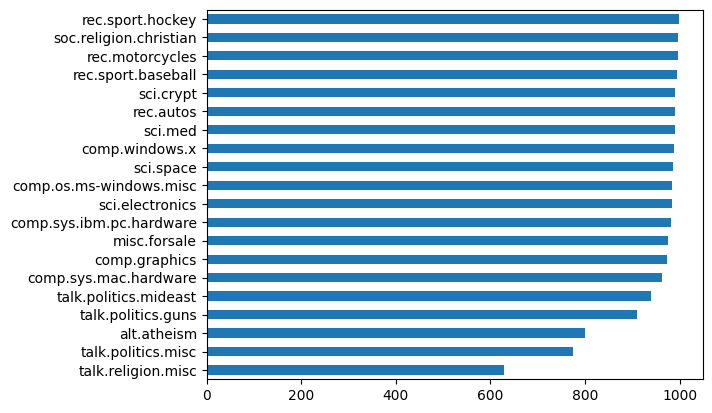

In [65]:
for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, unique_labels[label_index]))
    
df.label.value_counts().plot.barh()
plt.gca().invert_yaxis()

Below we provide an example of samples taken from three different labels:

In [11]:
print('First example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))
print('-' * 64)
print('Second example: sample number {} (label: {})\n\n{}\n'.format(
    1000, df.label[1000], df.text[1000]))
print('-' * 64)
print('Third example: sample number {} (label: {})\n\n{}\n'.format(
    4444, df.label[4444], df.text[4444]))

First example: sample number 200 (label: sci.electronics)

Does anyone know causes ever-growing black border around edges computer screen? The growth gradual know long taken get bad. 19" DEC (?) color monitor, maybe five years old, black border 1.1 inches left right sides, 1.75 inches bottom negligible top screen. The controls brightness knob, contrast knob, deGauss switch, power switch. anything done, monitor's days numbered?

----------------------------------------------------------------
Second example: sample number 1000 (label: talk.politics.misc)

The speed limit commuter tracks northeast 120MPH. already something resembles high speed rail country requires massive government subsidies. need another government boondoggle.

----------------------------------------------------------------
Third example: sample number 4444 (label: soc.religion.christian)

What basis idea hell place eternal suffering? Biblical, please reference. Here's train thought: God using Earth manufacture heave

### Systematic cleaning

In [66]:
# TODO Tokenise, remove double white spaces

In [12]:
# Remove HTML tages (everything within the "<>" brackets")
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)
df['text'] = df['text'].apply(remove_html_tags)

In [13]:
# Keep only alphabetical characters (26 roman letters)
def keep_only_alphas(text):
    return ' '.join(re.findall("[a-zA-Z]+", text))
df['text'] = df['text'].apply(keep_only_alphas)

In [14]:
# Set to lowercase
def set_to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(set_to_lowercase)

In [68]:
# Remove most common words ("it", "your", "as", etc.) as they are void of informational content for clustering
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [16]:
# Remove short words that are only one or two letters long
def remove_short_words(text):
    length_threshold = 2
    return ' '.join(word for word in text.split() if len(word)>length_threshold)
df['text'] = df['text'].apply(remove_short_words)

In [69]:
# Lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

def apply_lemmatization(text):
    word_tokens = word_tokenize(text)    
    pos_tags = pos_tag(word_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word_tokens, get_wordnet_pos(tag)) for word_tokens, tag in pos_tags]
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(apply_lemmatization)    

### Tailored cleaning

In [70]:
# We print the 200 most common words of the entire dataset
count = Counter(w for x in df['text'] for w in x.split())
most_commons = count.most_common(200)
print(most_commons)

[('use', 10700), ('say', 7792), ('know', 7477), ('make', 6943), ('like', 6660), ('think', 6596), ('people', 6496), ('time', 6003), ('well', 5495), ('see', 5110), ('max', 4720), ('work', 4693), ('good', 4513), ('year', 4346), ('take', 4342), ('system', 4290), ('new', 4216), ('file', 4119), ('come', 4018), ('want', 3970), ('find', 3947), ('even', 3888), ('look', 3841), ('right', 3788), ('give', 3775), ('way', 3755), ('need', 3720), ('thing', 3712), ('problem', 3694), ('first', 3600), ('god', 3593), ('get', 3572), ('edu', 3391), ('try', 3326), ('call', 3315), ('program', 3263), ('run', 3256), ('post', 3061), ('point', 3016), ('include', 2970), ('question', 2894), ('window', 2870), ('state', 2762), ('believe', 2739), ('drive', 2722), ('anyone', 2721), ('tell', 2707), ('mean', 2697), ('number', 2688), ('seem', 2662), ('read', 2577), ('back', 2552), ('since', 2538), ('please', 2523), ('something', 2487), ('day', 2444), ('game', 2421), ('image', 2415), ('help', 2413), ('really', 2393), ('stil

In [32]:
# We identify and remove words that do not carry a semantically meaningful information for clustering
extra_stop_words = ['one', 'would', 'get', 'also', 'could', 'may', 'two', 'much', 'many', 'going', 'three']
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (extra_stop_words)]))

### Visualization of the cleansed dataset

In [62]:
# Example of a single clean entry
print('Example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))

Example: sample number 200 (label: sci.electronics)

anyone know cause ever grow black border around edge computer screen growth gradual know long take bad dec color monitor maybe five year old black border inch leave right side inch bottom negligible top screen control brightness knob contrast knob degauss switch power switch anything do monitor day number



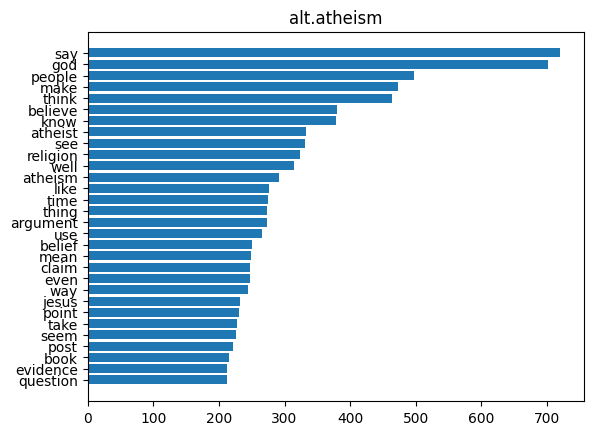

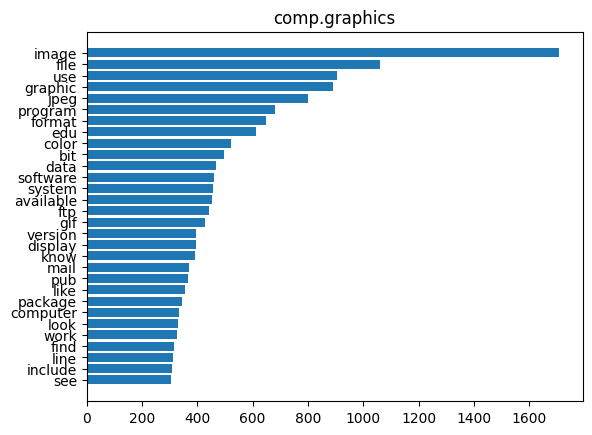

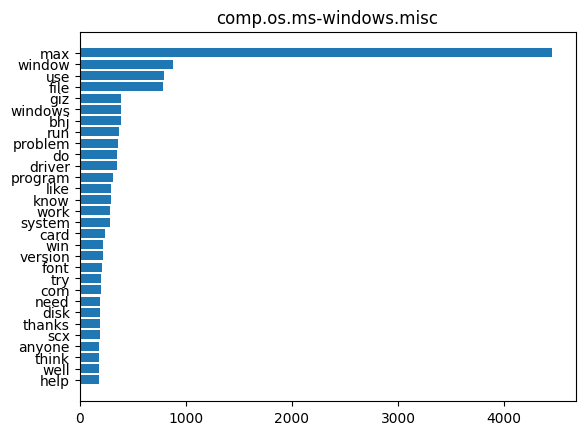

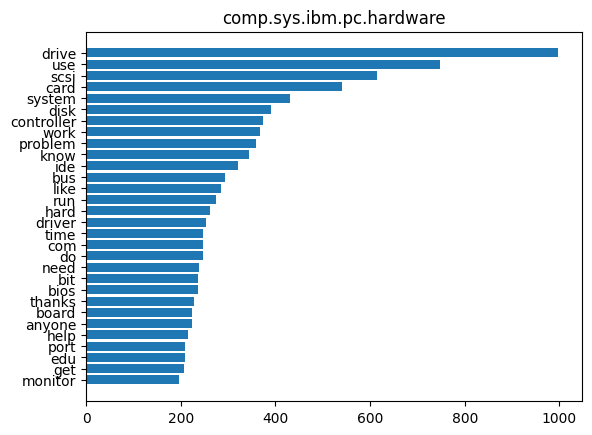

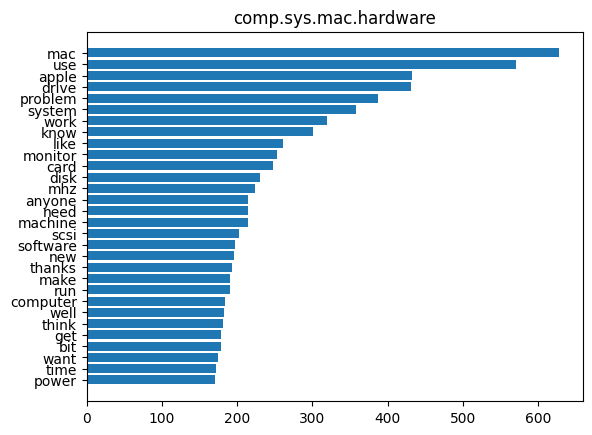

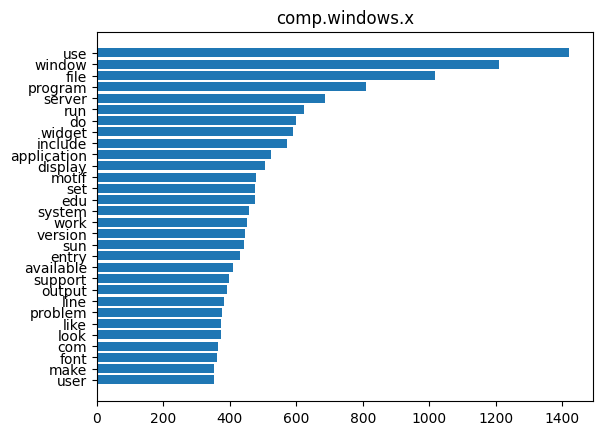

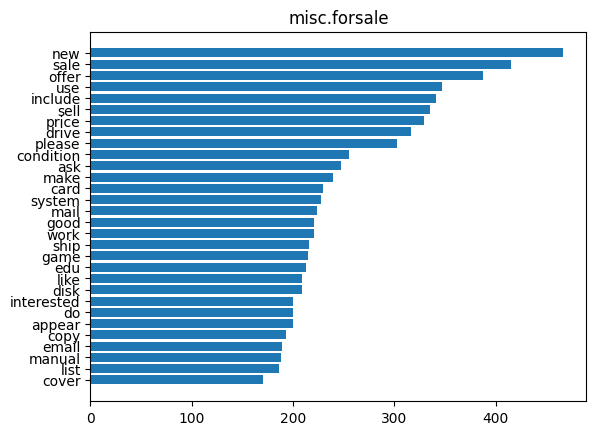

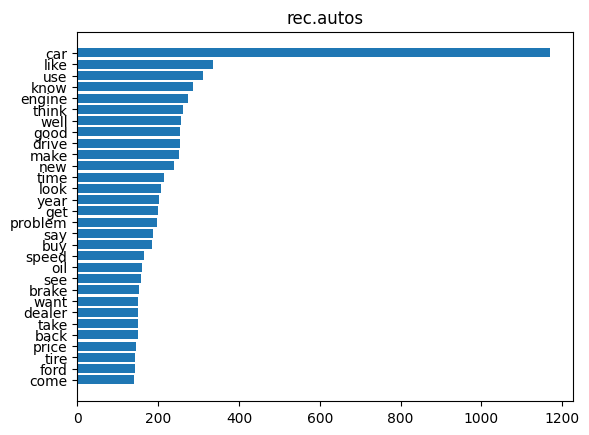

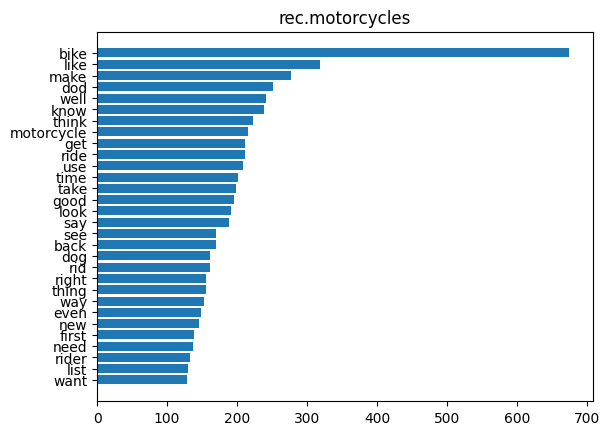

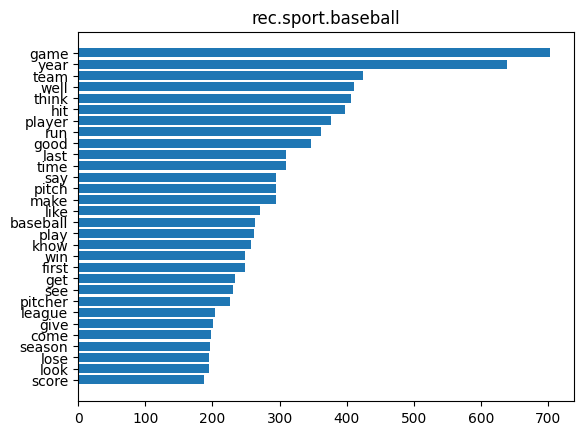

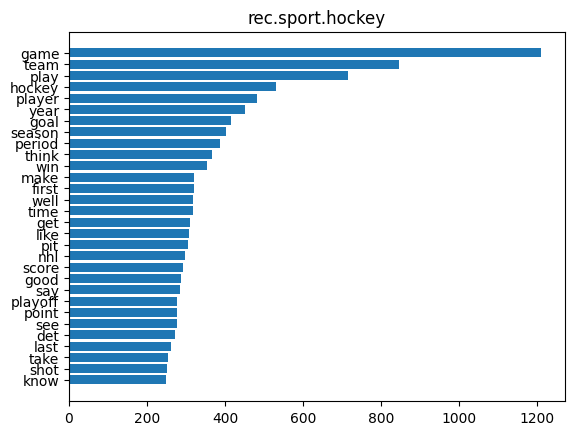

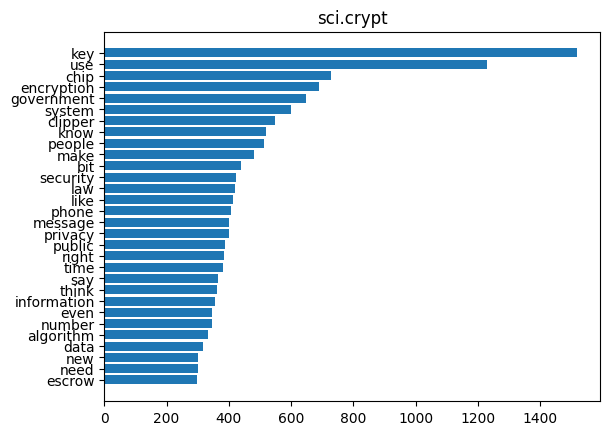

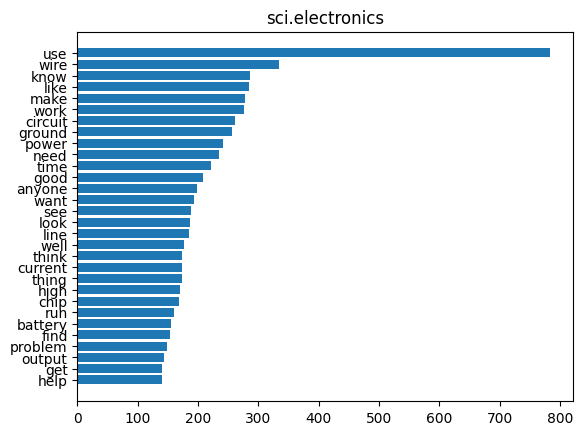

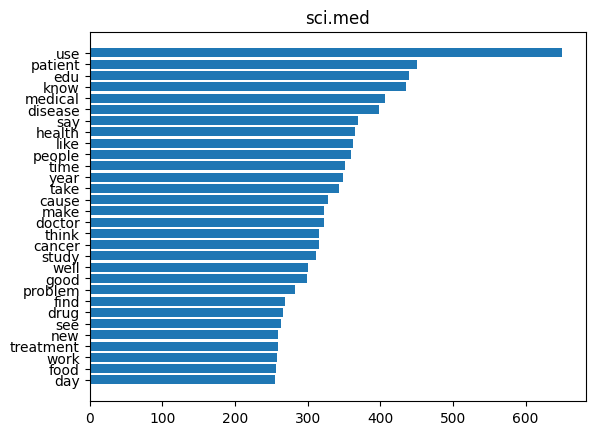

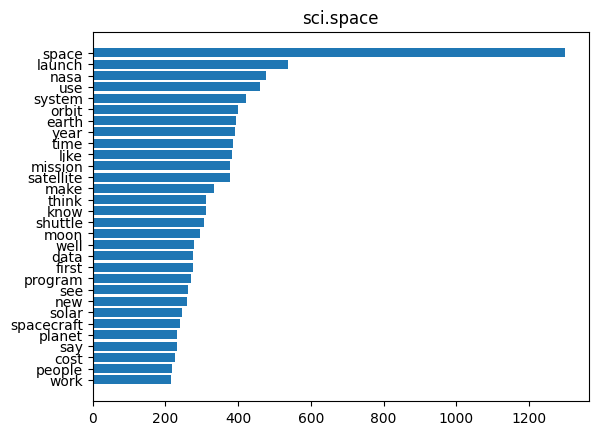

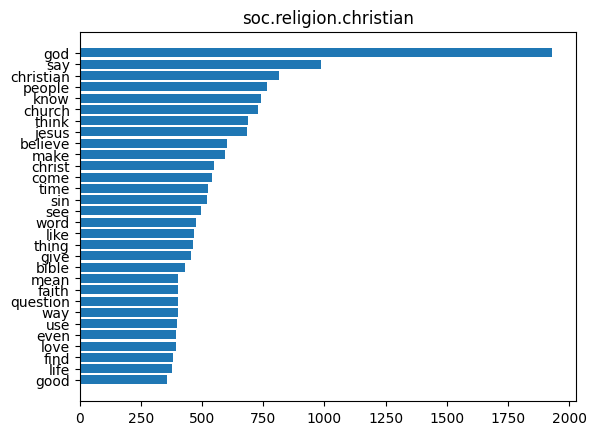

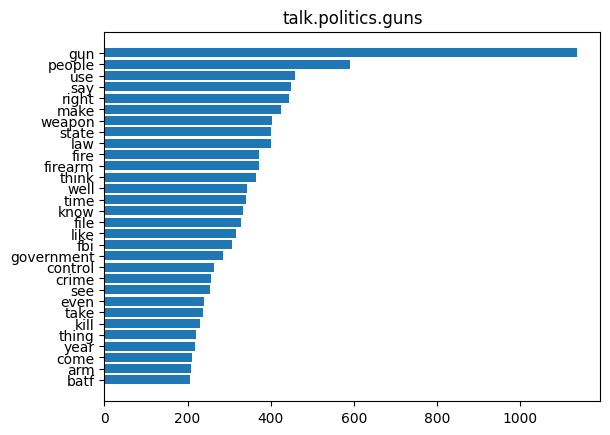

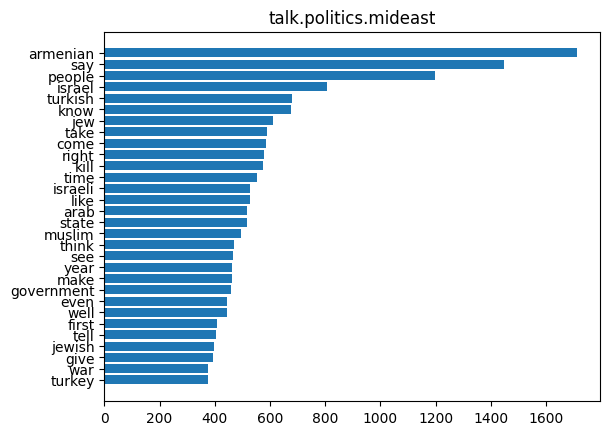

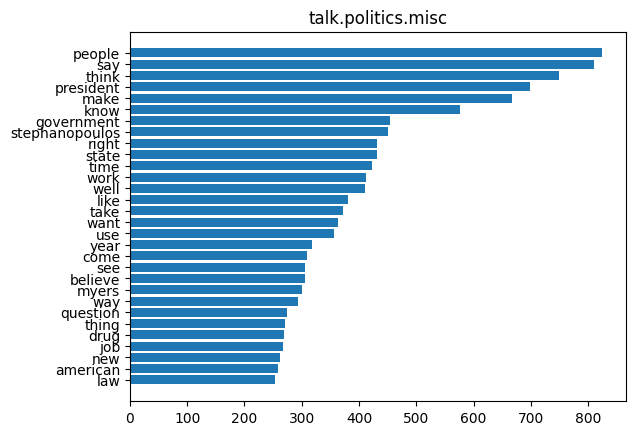

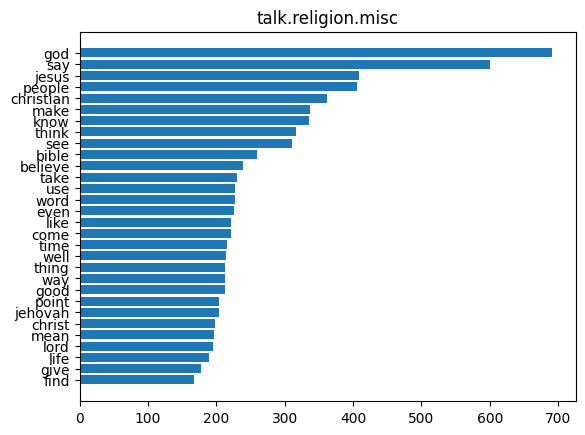

In [63]:
# We display the most common 30 words for each label. We observe that a strong semantic association emmerges between the label of each newsgroup and the most common words.
for label_index in range(number_of_unique_labels):
    label = unique_labels[label_index]
    
    df_single = df[df['label'].isin({label})]
    count = Counter(w for x in df_single['text'] for w in x.split())
    most_commons = count.most_common(30)

    plt.figure()
    plt.barh(*zip(*most_commons));
    plt.gca().invert_yaxis()
    plt.title(label)

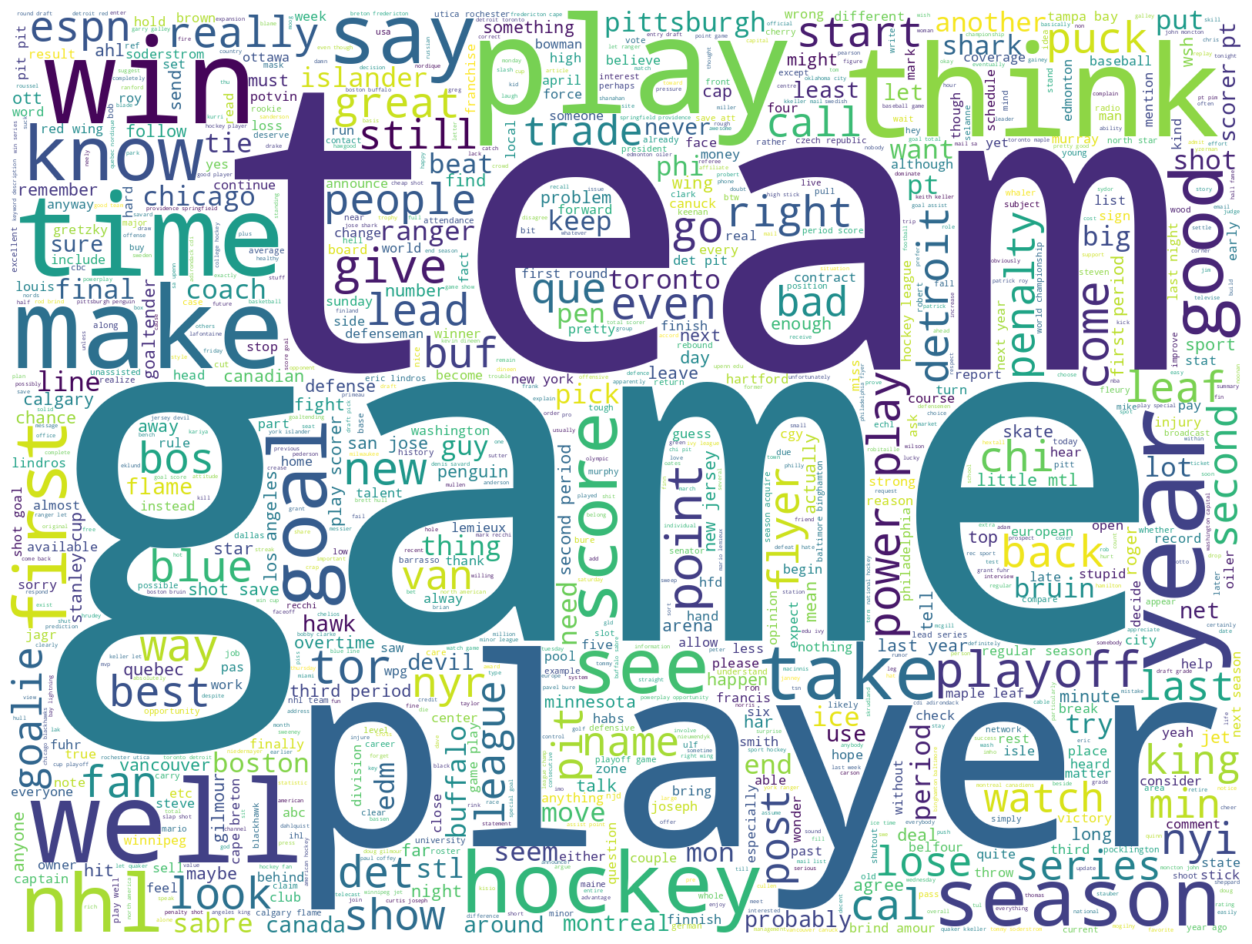

In [64]:
# Alternative representation of the most common words, for the label 'rec.sport.hockey' 
wordcloud = WordCloud(background_color="white", max_words=1000, random_state = random_seed, width=1600, height=1200)
df_hockey = df[df['label'].isin({'rec.sport.hockey'})]
df_hockey = df_hockey.text.tolist()
df_hockey = ' '.join(df_hockey)
wordcloud.generate(df_hockey)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
print(X.shape)

(18846, 85962)


### k-means

In [49]:
km = KMeans(n_clusters=number_of_unique_labels, init='k-means++', max_iter=100)
km.fit(X)


centroids = km.cluster_centers_.argsort()[:,::-1] 
terms = vectorizer.get_feature_names_out()
for cluster_index in range(number_of_unique_labels):
    print('Cluster {}'.format(cluster_index))
    for centroid_index in centroids[cluster_index, :10]:
        print(' %s' % terms[centroid_index], end='')
    print()





Cluster 0
 amount space pageovercommit value virtual address multiplier limit ini memory
Cluster 1
 win games trumbull illitch kittys gully harwell henneman krueger pitching
Cluster 2
 radio prosecuted neo nazis informed nazi reduce bbs risk fun
Cluster 3
 armenian armenians turkish armenia genocide turkey turks people soviet muslim
Cluster 4
 like know think people anyone use thanks good time please
Cluster 5
 mcmaster nguyen fmr unsubcribe research overflow unsubscribe flex philip mail
Cluster 6
 application server openwindows pulldown motif sunos menu terminal patch periodically
Cluster 7
 duties shipped refundable unadulterated experience refunded shi salesperson payable misfortune
Cluster 8
 cycnicism fakult jennifer irony sarcasm humor loop thrown confused contain
Cluster 9
 jailing thorson meme advocacy followups advocate jail ugly directed politics
Cluster 10
 xcomm lines makefile command barfs startingwith imakefiles xmkmf dislike edit
Cluster 11
 eeee eeeee tttttt liu steve c